* Prepping data for 2 strategies, a regression problem and two classification problems.
* For classification, I am binning the target variable into 15 minute ranges and 30 minute ranges.
* In all cases, I am binning all weather data.
* I will already proceed to deal with null values to save a clean dataframe.
* I will also deal with outliers. I find all the durations below 10 minutes to be irrelevant. The same can be said about outlier durations above the upper whisker (5 hours). These durations probably fall into planned works or extreme conditions that are irrelevant at this stage.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from time import time
import holidays

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
data_import = pd.read_csv('W9 - ProjectData_2.csv')
data_import.head()

,station_id,station_code,station_name,latitude,longitude,date,time_start,time_end,month,day_of_week,holiday,malfunction_cause,malfunction_cause_group,duration_minutes,avg_temp,rain_mm,highest_mean_wind_speed,avg_relative_humidity,radiation,avg_visibility
0,8400244,GDM,Geldermalsen,51.883010,5.271270,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5
1,8400319,HT,'s-Hertogenbosch,51.690480,5.293620,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5
2,8400732,ZBM,Zaltbommel,51.808887,5.263333,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5
3,8400226,ALMO,Almere Oostvaarders,52.403332,5.300556,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5
4,8400394,LLS,Lelystad Centrum,52.507778,5.472778,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5


# 1. Binning features and creating column with peak and off-peak hours

#### *Null values have already been cleaned from this dataset

## 1.1. Binning rain, wind and temperature

In [4]:
data_import['rain_bins'] = pd.qcut(data_import['rain_mm'],labels=["low", "medium", "high"], q=3,precision=0)
data_import['wind_bins'] = pd.qcut(data_import['highest_mean_wind_speed'],labels=["low", "medium", "high"], q=3,precision=1)
data_import['temp_bins'] = pd.qcut(data_import['avg_temp'],labels=["freezing", "chilly","warm", "hot"], q=4,precision=1)

In [5]:
data_import.head()

,station_id,station_code,station_name,latitude,longitude,date,time_start,time_end,month,day_of_week,holiday,malfunction_cause,malfunction_cause_group,duration_minutes,avg_temp,rain_mm,highest_mean_wind_speed,avg_relative_humidity,radiation,avg_visibility,rain_bins,wind_bins,temp_bins
0,8400244,GDM,Geldermalsen,51.883010,5.271270,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly
1,8400319,HT,'s-Hertogenbosch,51.690480,5.293620,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly
2,8400732,ZBM,Zaltbommel,51.808887,5.263333,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly
3,8400226,ALMO,Almere Oostvaarders,52.403332,5.300556,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5,medium,medium,chilly
4,8400394,LLS,Lelystad Centrum,52.507778,5.472778,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5,medium,medium,chilly


## 1.2. TIME: peak - off peak

In [6]:
time = data_import[['day_of_week', 'time_start','time_end','holiday']].copy()

In [7]:
time[['hour', 'minute', 'second']] = time['time_start'].str.split(':', 2, expand=True)

In [8]:
time['hour'] = time['hour'].astype('int64')

In [9]:
def times(row):
    if (((row['hour']> 6) and (row['hour']< 9)) or ((row['hour']>= 16) and (row['hour']< 19))) and ((row['day_of_week'] != 'Saturday') and (row['day_of_week'] != 'Sunday')):
        val = 'peak'            
    else:
        val = 'off-peak'

    return val 

In [10]:
time['time_type'] = time.apply(times, axis=1)

In [11]:
time.head()

,day_of_week,time_start,time_end,holiday,hour,minute,second,time_type
0,Tuesday,06:32:16,06:33:31,True,6,32,16,off-peak
1,Tuesday,06:32:16,06:33:31,True,6,32,16,off-peak
2,Tuesday,06:32:16,06:33:31,True,6,32,16,off-peak
3,Tuesday,07:12:00,09:53:48,True,7,12,00,peak
4,Tuesday,07:12:00,09:53:48,True,7,12,00,peak


In [12]:
data_import = data_import.join(time['time_type'])

In [13]:
data_import.head()

,station_id,station_code,station_name,latitude,longitude,date,time_start,time_end,month,day_of_week,holiday,malfunction_cause,malfunction_cause_group,duration_minutes,avg_temp,rain_mm,highest_mean_wind_speed,avg_relative_humidity,radiation,avg_visibility,rain_bins,wind_bins,temp_bins,time_type
0,8400244,GDM,Geldermalsen,51.883010,5.271270,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly,off-peak
1,8400319,HT,'s-Hertogenbosch,51.690480,5.293620,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly,off-peak
2,8400732,ZBM,Zaltbommel,51.808887,5.263333,2019-01-01,06:32:16,06:33:31,1,Tuesday,True,damaged overhead wires,infrastructure,1.0,74.5,2,50,77,177,55.5,medium,medium,chilly,off-peak
3,8400226,ALMO,Almere Oostvaarders,52.403332,5.300556,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5,medium,medium,chilly,peak
4,8400394,LLS,Lelystad Centrum,52.507778,5.472778,2019-01-01,07:12:00,09:53:48,1,Tuesday,True,vandalism,external,162.0,74.5,2,50,77,177,55.5,medium,medium,chilly,peak


# 2. Changing dtypes

In [14]:
data_import.dtypes

station_id                    int64
station_code                 object
station_name                 object
latitude                    float64
longitude                   float64
date                         object
time_start                   object
time_end                     object
month                         int64
day_of_week                  object
holiday                        bool
malfunction_cause            object
malfunction_cause_group      object
duration_minutes            float64
avg_temp                    float64
rain_mm                       int64
highest_mean_wind_speed       int64
avg_relative_humidity         int64
radiation                     int64
avg_visibility              float64
rain_bins                  category
wind_bins                  category
temp_bins                  category
time_type                    object
dtype: object

In [15]:
data_import['duration_minutes'] = data_import['duration_minutes'].astype('int64')
data_import[['month', 'holiday','rain_bins', 'wind_bins', 'temp_bins']] = data_import[['month', 'holiday','rain_bins', 'wind_bins','temp_bins']].astype('object')

# 3. Dropping columns

In [16]:
data = data_import.drop(['station_id','station_code','date','avg_temp','rain_mm','highest_mean_wind_speed','avg_relative_humidity','radiation','avg_visibility', 'time_start','time_end'], axis = 1)

In [17]:
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,malfunction_cause,malfunction_cause_group,duration_minutes,rain_bins,wind_bins,temp_bins,time_type
0,Geldermalsen,51.883010,5.271270,1,Tuesday,True,damaged overhead wires,infrastructure,1,medium,medium,chilly,off-peak
1,'s-Hertogenbosch,51.690480,5.293620,1,Tuesday,True,damaged overhead wires,infrastructure,1,medium,medium,chilly,off-peak
2,Zaltbommel,51.808887,5.263333,1,Tuesday,True,damaged overhead wires,infrastructure,1,medium,medium,chilly,off-peak
3,Almere Oostvaarders,52.403332,5.300556,1,Tuesday,True,vandalism,external,162,medium,medium,chilly,peak
4,Lelystad Centrum,52.507778,5.472778,1,Tuesday,True,vandalism,external,162,medium,medium,chilly,peak


# 4. Interesting Data

In [18]:
df_cause_avgtime = data.groupby(['malfunction_cause_group','malfunction_cause'])['duration_minutes'].mean().round(1).to_frame()
df_cause_avgtime.head()

duration_minutes
malfunction_cause_group malfunction_cause                         
accidents               collision                             68.2
                        collision with a vehicle             141.0
                        collision with an animal              45.2
                        damaged level crossing                61.5
                        damaged railway bridge                47.6

In [19]:
df_cause_count = data.groupby('malfunction_cause_group')['malfunction_cause'].value_counts().to_frame().rename(columns = {'malfunction_cause':'amount_2019'})
df_cause_count.head()

amount_2019
malfunction_cause_group malfunction_cause                    
accidents               person hit by a train            1643
                        collision                         523
                        damaged railway bridge            366
                        collision with a vehicle          227
                        collision with an animal           86

# 5. Dropping the outlier times (>5h)
* Although dropping outliers is risky business (e.g. house prices - the model would not be able to predict outlier prices), in this specific case, it makes sense to drop the outliers from duration_minutes.
* For this specific problem we are trying to predict the time it will take for a malfunction to be resolved. That means that the user will have been castaway presently. The value of a duration above 24h (exaggerating) makes no sense, since this will have probably been reported already 
* When the value of duration_minutes is 295.50 (5h) we can assume that such a prediction will already allow a user to make the decision to search for an alternative means of transport.
* We avoid dealing with outliers that probably result from planned engineering works or are a cause of some exceptional event.

In [20]:
data_num = data.select_dtypes(include=['int64'])

In [21]:
for col in data_num.columns:
    iqr = np.percentile(data_num[col],75) - np.percentile(data_num[col],25)
    upper_limit = np.percentile(data_num[col],75) + 1.5*iqr
    lower_limit = np.percentile(data_num[col],75) - 1.5*iqr
    print("For column {}:".format(col))
    print("the upper wisker is at: %4.2f" % upper_limit)
    print("the lower wisker is at: %4.2f" % lower_limit)
    outliers_upper = data_num[data_num[col] > upper_limit].index.tolist()
    outliers_lower = data_num[data_num[col] < lower_limit].index.tolist()
    print("the number of points outise the upper wisker is: ",len(outliers_upper))
    print("the number of points outise the lower wisker is: ",len(outliers_lower))

For column duration_minutes:
the upper wisker is at: 295.50
the lower wisker is at: -43.50
the number of points outise the upper wisker is:  1925
the number of points outise the lower wisker is:  0


### 5.1. I will filter out the times above 5h and also below 10 minutes (which is irrelevant for the problem at hand)

In [22]:
data = data[(data["duration_minutes"]>10) & (data["duration_minutes"]<295.50)]
len(data)

19041

In [23]:
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,malfunction_cause,malfunction_cause_group,duration_minutes,rain_bins,wind_bins,temp_bins,time_type
3,Almere Oostvaarders,52.403332,5.300556,1,Tuesday,True,vandalism,external,162,medium,medium,chilly,peak
4,Lelystad Centrum,52.507778,5.472778,1,Tuesday,True,vandalism,external,162,medium,medium,chilly,peak
5,Ermelo,52.301666,5.614722,1,Tuesday,True,signal failure,infrastructure,17,medium,medium,chilly,peak
6,Harderwijk,52.337502,5.619722,1,Tuesday,True,signal failure,infrastructure,17,medium,medium,chilly,peak
7,Putten,52.264999,5.575278,1,Tuesday,True,signal failure,infrastructure,17,medium,medium,chilly,peak


In [24]:
data.columns

Index(['station_name', 'latitude', 'longitude', 'month', 'day_of_week',
       'holiday', 'malfunction_cause', 'malfunction_cause_group',
       'duration_minutes', 'rain_bins', 'wind_bins', 'temp_bins', 'time_type'],
      dtype='object')

In [25]:
data = data[['station_name', 'latitude', 'longitude', 'month', 'day_of_week', 'holiday', 'time_type', 'malfunction_cause',
       'malfunction_cause_group', 'rain_bins', 'wind_bins',
       'temp_bins', 'duration_minutes']]
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,time_type,malfunction_cause,malfunction_cause_group,rain_bins,wind_bins,temp_bins,duration_minutes
3,Almere Oostvaarders,52.403332,5.300556,1,Tuesday,True,peak,vandalism,external,medium,medium,chilly,162
4,Lelystad Centrum,52.507778,5.472778,1,Tuesday,True,peak,vandalism,external,medium,medium,chilly,162
5,Ermelo,52.301666,5.614722,1,Tuesday,True,peak,signal failure,infrastructure,medium,medium,chilly,17
6,Harderwijk,52.337502,5.619722,1,Tuesday,True,peak,signal failure,infrastructure,medium,medium,chilly,17
7,Putten,52.264999,5.575278,1,Tuesday,True,peak,signal failure,infrastructure,medium,medium,chilly,17


### 5.2. Change month and holiday

In [26]:
months = {1: "January", 2: "February",3: "March", 4: "April",5: "May", 6: "June",7: "July", 8: "August",9: "September", 10: "October",11: "November", 12: "December"}

In [27]:
data['month'] = data['month'].map(months)

In [28]:
holiday = {True: "holiday", False: "nonholiday"}

In [29]:
data['holiday'] = data['holiday'].map(holiday)

In [30]:
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,time_type,malfunction_cause,malfunction_cause_group,rain_bins,wind_bins,temp_bins,duration_minutes
3,Almere Oostvaarders,52.403332,5.300556,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162
4,Lelystad Centrum,52.507778,5.472778,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162
5,Ermelo,52.301666,5.614722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17
6,Harderwijk,52.337502,5.619722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17
7,Putten,52.264999,5.575278,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17


# 6. Save as csv - target not binned

In [31]:
data.to_csv(r'C:\Users\yelam\OneDrive\Escritorio\IRONHACK\WEEK 9 - Project\W9 - Project - project csv\W9 - ProjectData_3-num_duration.csv', index = False, header=True)

# 7. Binning duration minutes for classification problem

## 7.1. 30-minute intervals

In [32]:
max(data["duration_minutes"])

295

In [33]:
cut_labels_30 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
cut_bins_30 = list(range(0, 301, 30))
data["duration_30min_intervals"] = pd.cut(data["duration_minutes"], bins=cut_bins_30, labels=cut_labels_30)

## 7.2. 15-minute intervals

In [34]:
cut_bins_15 = list(range(0, 301, 15))
print(cut_bins_15)

[0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300]


In [35]:
cut_labels_15 = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t']
cut_bins_15 = list(range(0, 301, 15))
data["duration_15min_intervals"] = pd.cut(data["duration_minutes"], bins=cut_bins_15, labels=cut_labels_15)

In [36]:
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,time_type,malfunction_cause,malfunction_cause_group,rain_bins,wind_bins,temp_bins,duration_minutes,duration_30min_intervals,duration_15min_intervals
3,Almere Oostvaarders,52.403332,5.300556,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162,f,k
4,Lelystad Centrum,52.507778,5.472778,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162,f,k
5,Ermelo,52.301666,5.614722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b
6,Harderwijk,52.337502,5.619722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b
7,Putten,52.264999,5.575278,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b


In [37]:
data['duration_30min_intervals'] = data['duration_30min_intervals'].astype('object')

In [38]:
data['duration_15min_intervals'] = data['duration_15min_intervals'].astype('object')

## 7.3. Split into 2 dataframes (15 min. and 30 min. intervals)

### 7.3.1. 15min.

In [39]:
data.head()

,station_name,latitude,longitude,month,day_of_week,holiday,time_type,malfunction_cause,malfunction_cause_group,rain_bins,wind_bins,temp_bins,duration_minutes,duration_30min_intervals,duration_15min_intervals
3,Almere Oostvaarders,52.403332,5.300556,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162,f,k
4,Lelystad Centrum,52.507778,5.472778,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,162,f,k
5,Ermelo,52.301666,5.614722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b
6,Harderwijk,52.337502,5.619722,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b
7,Putten,52.264999,5.575278,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,17,a,b


In [40]:
data_15 = data.drop(['latitude','longitude','duration_minutes','duration_30min_intervals'], axis=1).copy()

In [41]:
data_15.to_csv(r'C:\Users\yelam\OneDrive\Escritorio\IRONHACK\WEEK 9 - Project\W9 - Project - project csv\W9 - ProjectData_3-int15.csv', index = False, header=True)

### 7.3.1. 30min.

In [42]:
data_30 = data.drop(['latitude','longitude','duration_minutes','duration_15min_intervals'], axis=1).copy()

In [43]:
data_30.to_csv(r'C:\Users\yelam\OneDrive\Escritorio\IRONHACK\WEEK 9 - Project\W9 - Project - project csv\W9 - ProjectData_3-int30.csv', index = False, header=True)

In [44]:
data_30.head()

,station_name,month,day_of_week,holiday,time_type,malfunction_cause,malfunction_cause_group,rain_bins,wind_bins,temp_bins,duration_30min_intervals
3,Almere Oostvaarders,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,f
4,Lelystad Centrum,January,Tuesday,holiday,peak,vandalism,external,medium,medium,chilly,f
5,Ermelo,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,a
6,Harderwijk,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,a
7,Putten,January,Tuesday,holiday,peak,signal failure,infrastructure,medium,medium,chilly,a


In [45]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

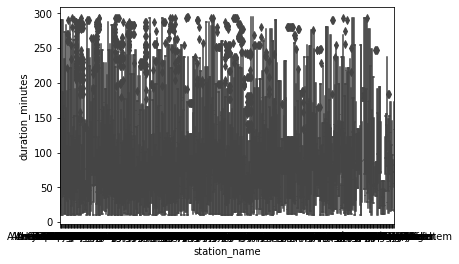

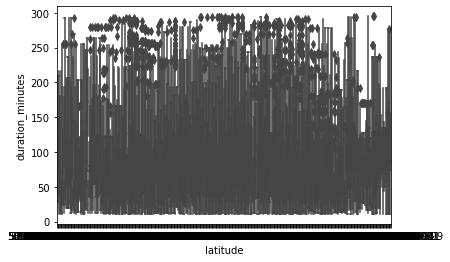

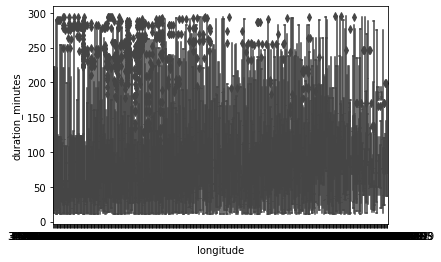

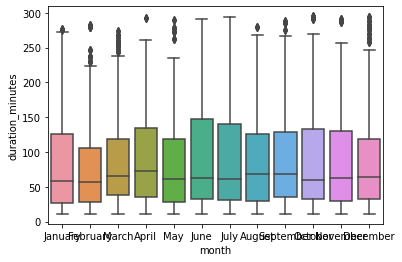

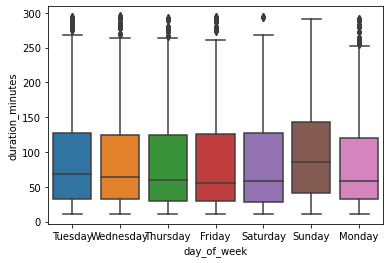

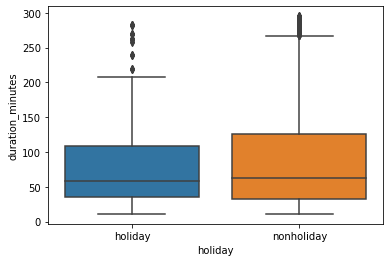

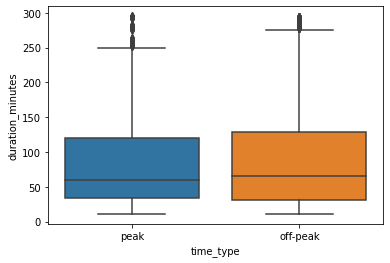

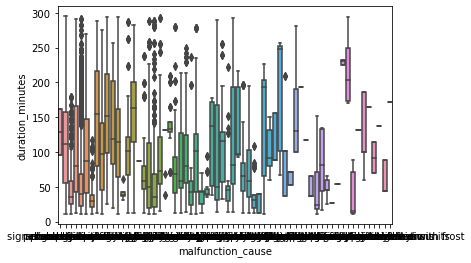

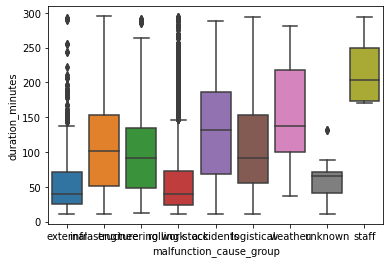

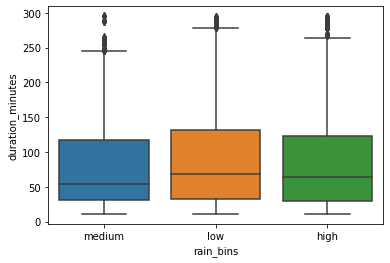

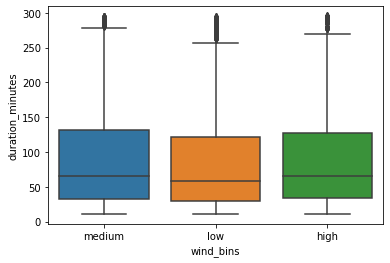

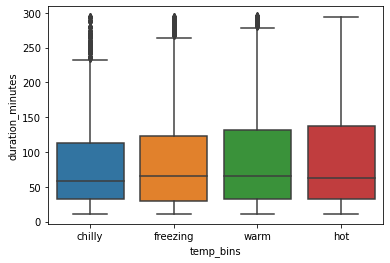

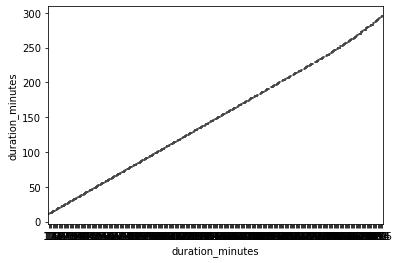

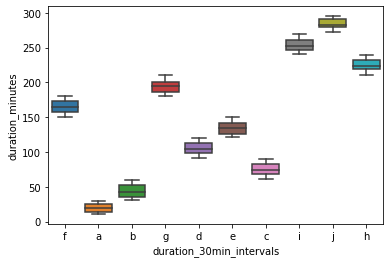

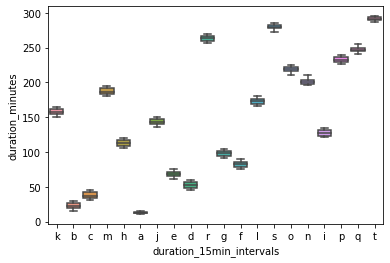

In [46]:
for col in data.columns:
    sns.boxplot(x = col,y='duration_minutes', data=data)
    plt.show()